# Satellite Image Classification

Show how using deep learning can be applied to satellite images. how additonal hyperspectral bands contain very useful information that can be taken advantage of with deep learning. Losley following these papers https://www.isprs-ann-photogramm-remote-sens-spatial-inf-sci.net/III-7/83/2016/isprs-annals-III-7-83-2016.pdf and https://arxiv.org/pdf/1509.03602.pdf

## Import libraries 

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import swat as sw
s = sw.CAS('localhost',5570,'sas', 'Orion123')
s.loadactionset('deepLearn')

NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0164s, user: 0.00023s, sys: 0.00251s, mem: 0.196mb

## Explore and Prepare Data
Steps to download and prepare the SAT-6 dataset to be used by SAS Viya as well as get an idea of its contents. 

### Using the Kaggle API to download SAT-6 dataset
The [Kaggle API](https://github.com/Kaggle/kaggle-api) provides an easy way to download datasets from their website. It is assumed the Kaggle package is already installed and the user has followed the instructions for setting up their credentials (see link above to get started if this is not the case). 

In [2]:
# download the dataset (-d) located in crawford/deepsat-sat
# Specify the path (-p) where you'd like the data to be downloaded (./data/SAT6/)
! kaggle datasets download -d crawford/deepsat-sat6 -p ./data/SAT6/

/usr/bin/sh: kaggle: command not found


Contents of deepsat-sat6 dataset

### Initial Data Exploration 

We will be using both the training and test csv files as well as the annotations file from this download. To get an idea of what these files look like we can view a small subset of rows from our X_train and y_train files.

In [3]:
xtrain_sample = pd.read_csv('data/SAT6/X_train_sat6.csv', header=None, nrows=100, dtype='uint8') # load pixel table 
ytrain_sample = pd.read_csv('data/SAT6/y_train_sat6.csv', header=None, nrows=100) # load label table
annotations = pd.read_csv('data/SAT6/sat6annotations.csv', header=None) # load label annotation table

The pixel table contains 3136 columns per row. This corresponds to a flattened 28x28 pixel image with 4 channels. As discussed in the Kaggle overview each image contains the standard RGB channels, but also includes a NIR (near infarred) channel. With the goal of classifying the landscape in the image, the NIR channel would contain some very useful information outside of the standard RBG contents that could help in this task. 

In [4]:
xtrain_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,116,119,118,159,108,113,118,150,67,60,...,21,80,56,47,38,94,69,67,61,103
1,177,152,129,183,180,154,128,182,181,156,...,128,171,182,164,135,173,182,160,136,174
2,20,34,72,10,27,45,76,13,39,92,...,81,8,47,127,93,9,58,137,102,12
3,102,92,136,20,134,156,144,33,135,162,...,69,5,27,51,67,6,36,54,73,6
4,122,140,156,34,124,155,151,32,135,165,...,157,34,113,142,151,24,101,115,149,21


The label table is a one hot encoded vector of all the classes the dataset contains. The shape of this dataframe would be 
(nrows,6) meaning there are 6 possible classes for our images. These classes are shown in the annotations table below.

In [5]:
ytrain_sample.head()

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [6]:
annotations.head(6)

,0,1,2,3,4,5,6
0,building,1,0,0,0,0,0
1,barren_land,0,1,0,0,0,0
2,trees,0,0,1,0,0,0
3,grassland,0,0,0,1,0,0
4,road,0,0,0,0,1,0
5,water,0,0,0,0,0,1


Using matplotlib we can view the images pretty easily. It is necessary to reshape the data first into a format suitable for plotting. From a flat row of pixels (3136 columns) to an array with shape (nrows,28,28,4).

In [7]:
x = xtrain_sample.values # create an array of pixel values from dataframe
x = x.reshape(x.shape[0],28,28,4) # reshape array for matplotlib imshow
x.shape

(100, 28, 28, 4)

Viewing just the first 3 channels (RGB) we can see the diffrent landscapes our model will ultimately try and classify. These are natural images and we would expect these to be similar to what we would see if we had an eagle eye view over these patches.

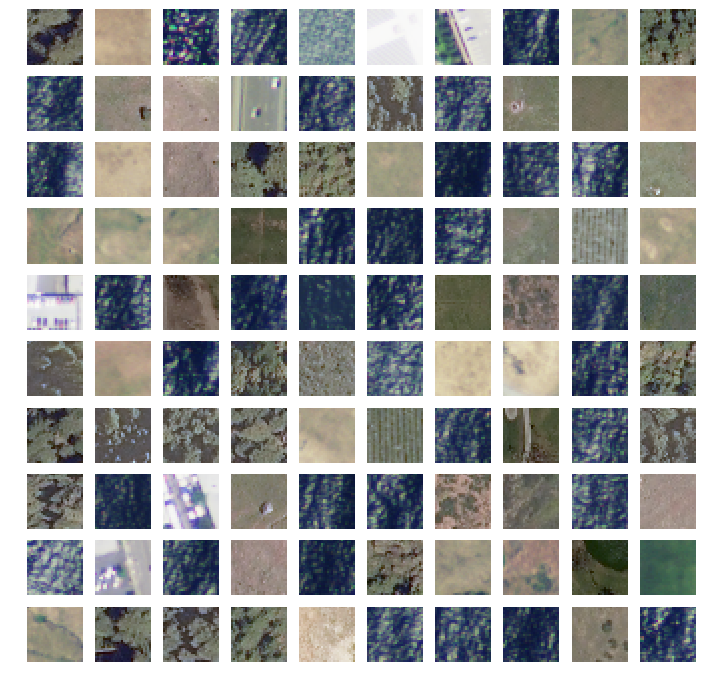

In [8]:
# Create figure and iteratively add images as subplots 
fig = plt.figure(figsize=(12,12))
for i in range(x.shape[0]):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(x[i,:,:,:3])
    ax.axis('off')

Adding the 4th channel (NIR) to the plot does not, at first, provide anything too useful. In fact it looks as if this additional channel makes the images more difficult to interpret. However, this does not mean the NIR channel isn't helpful for describing properties of the data.  

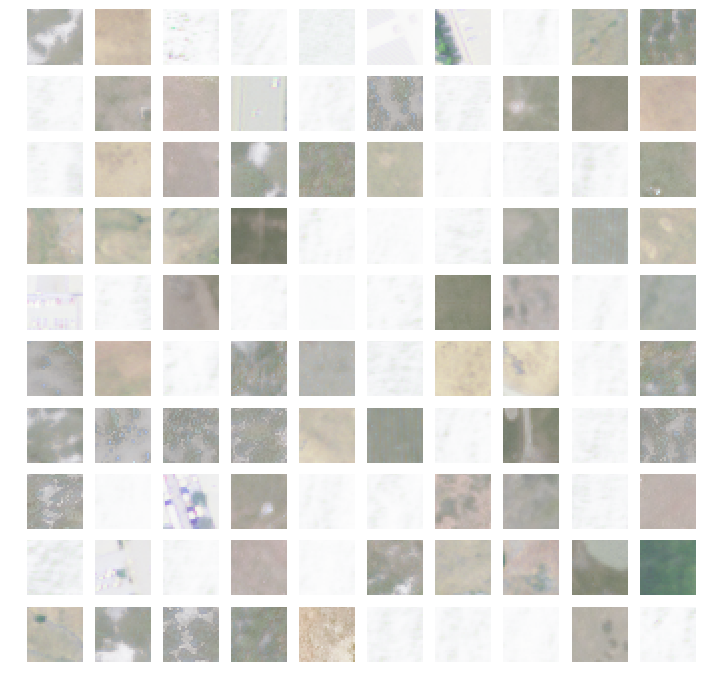

In [9]:
# Create figure and iteratively add images as subplots 
fig = plt.figure(figsize=(12,12))
for i in range(x.shape[0]):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(x[i,:,:,:])
    ax.axis('off')

It doesn't really make sense to overlay all 4 channels on top of one another. A natural image is made of 3 channels where each channel corresponds to the intensities of the R, G, and B values, as most visable colors can be created by combining these. In satalite imagery 3 channels are used but non-RGB channels are mapped to one of these naturally occuring visable light bands. By combining these different bands you can create images that show much more then just what the naked eye can see. These representations are refered to as "false-color" images and are extremely helpful in describing satalite imagery data. To read more about false-color images see [here](https://earthobservatory.nasa.gov/Features/FalseColor/).

One of the most frequently published combinations uses near infrared light as red, red light as green, and green light as blue.
In order to plot images with these mappings we can organize a new array made up of just these values and placed in the proper order.

In [10]:
x_r = x[:,:,:,0] # Red channel
x_g = x[:,:,:,1] # Green channel
x_b = x[:,:,:,2] # Blue channel
x_nir = x[:,:,:,3] # NIR channel

x_r.shape

(100, 28, 28)

In [11]:
x_NRG = np.stack((x_nir, x_r, x_g), axis=-1) # Stack these 3 arrays along the last axis to form our false-color image

Below is a plot using this false-color image and it returns some interesting results. Intepreting these results requires a little bit of initution behind why certain geographical areas refelect or absorb certain wavelengths of light. For example, water will absorb NIR light (light with a wavelength 700-1000nm) meaning light at this wavelength is not refelected and would not be captured by the satalitte. Since we mapped the NIR band to the red channel we expect water/wetland areas to appear darker with a low to zero density of red pixels. On the opposite side of this, plants refelect NIR light so we expect to see grassland and vegitative areas to have a high density of red pixels. The resulting images definetely reflect this.  

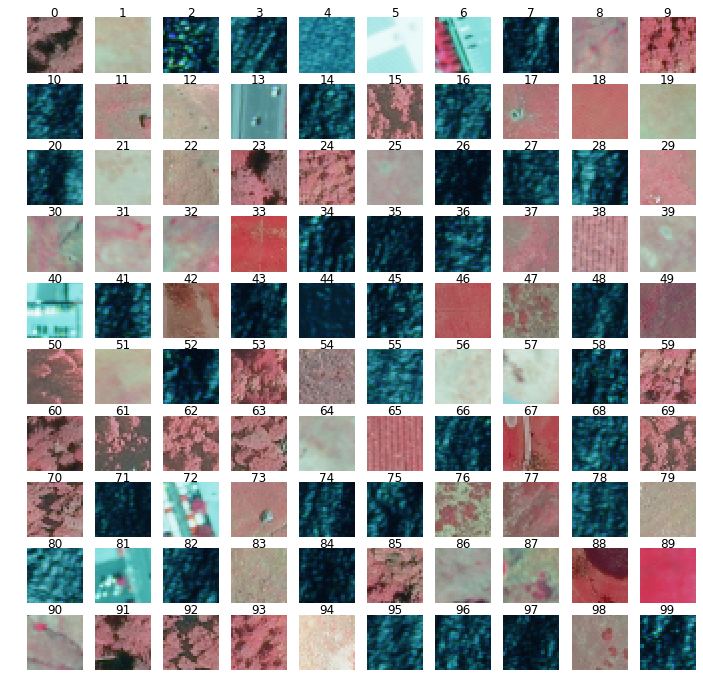

In [12]:
# Create figure and iteratively add images as subplots 
fig = plt.figure(figsize=(12,12))
for i in range(x.shape[0]):
    ax = fig.add_subplot(10,10,i+1)
    ax.set_title(i,pad=0.5)
    ax.imshow(x_NRG[i,:,:,:])
    ax.axis('off')

This type of false-color image is a traditional band combination useful in seeing changes in plant health. Meaning the more red a particular area is the healthier the plant life. Another useful result is discerning boundaries. Looking at image 98 from above you may notice pockets of bright red areas. Some boundaires are not as obvious in visiable light so using the false-color image in this way can be very benefical. Not to mention that pocket might be confused as wetland areas from the natural image but upon looking at the false-color image we see it is in fact pockets of plantlife. 

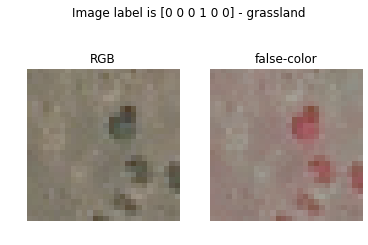

In [13]:
# Looking at image 98 above in both RGB and false-color mapping
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle('Image label is {} - grassland'.format(ytrain_sample.values[98]))

ax1.set_title('RGB')
ax1.imshow(x[98,:,:,:3])
ax1.axis('off')

ax2.set_title('false-color')
ax2.imshow(x_NRG[98,:,:,:])
ax2.axis('off')
plt.show()

### Create Final Table
While viewing this data is very important the objective of this notebook is to show how using a CNN can help classify these images into their landscape catagories. Before doing that we will prepare a final table with all the data and load this table into CAS. 

The final table will be the result of 
- Reversing the one hot encoded labels to their catagory names 
- Grouping the channel values from (r,g,b) to (rrr,..ggg,..)
- Joining the label and pixel tables

Once that is done the table will be uploaded to cas

*Note* - 
If you're enviorment has limited memory and/or you are getting memory errors see the bottom of the notebook for a couple of other options for creating the final table and loading into CAS.

In [ ]:
x_train = pd.read_csv('data/SAT6/X_train_sat6.csv', header=None, dtype='uint8') # load entire pixel train table
y_train = pd.read_csv('data/SAT6/y_train_sat6.csv', header=None) # load entire label train table
x_test = pd.read_csv('data/SAT6/X_test_sat6.csv', header=None, dtype='uint8') # load entire pixel test table
y_test = pd.read_csv('data/SAT6/y_test_sat6.csv', header=None) # load entire label test table

In [ ]:
# This returns a list containing the positions of the target variable in the
# one hot encoded vector for each image in our dataset
def reverse_onehot(y):
    l = []
    for row in y:
        m = row.argmax()
        l.append(m)
    return l

In [ ]:
y_train_rev = reverse_onehot(y_train.values)
y_test_rev = reverse_onehot(y_test.values)

In [ ]:
y_train_rev[:5]

In [ ]:
# This returns a dict with keys equal to the class name and 
# values equal to position of the target in a one hot encoded vector
d = {}
for row in annotations.values:
    d[row[0]] = row[1:].argmax()
d

In [ ]:
# This returns a list with the label names as opposed to one hot encoded vector 
def assign_label(d,y):
    for idx,row in enumerate(y):
        for k,v in d.items():
            if row == v:
                y[idx] = k
            else:
                continue
    return y

In [ ]:
# Create dataframe with single column 'label' 
label_train = pd.DataFrame(assign_label(d, y_train_rev), columns=['_label_'])
label_test = pd.DataFrame(assign_label(d, y_test_rev), columns=['_label_'])

In [ ]:
label_train.head()

In [ ]:
# Group channels into (rr,..,gg,..,bb,..,irir..)
def group_channels(x, n_ch=4):
    l = []
    for i in range(n_ch):
        l.append(x.loc[:,i::4]) # Slice through dataframe at r,g,b,ir positons and append to l
    df = pd.concat(l, axis=1) # Join columns and create single df
    df.columns = np.arange(len(df.columns)) # Create sequential column names
    return df

In [ ]:
x_train = group_channels(x_train)
x_test = group_channels(x_test)

In [ ]:
# Join pixel tables to label table 
train = x_train.join(label_train)
test = x_test.join(label_test)

In [ ]:
# Final dataframe which contains all image data and label names for targets
train.head()

In [ ]:
train.shape

### Calculate mean and std for each each channel
Later in the notebook when building the model we will want to normalize our dataset for training purposes. Consists of subtracting the per channel pixel mean and dividing by per channel std. This gives the dataset 0 mean and unit variance. The table below shows these values for reference. 

|  | Mean | STD |
| --- | --- | --- |
| R | 112.34 | 54.74 |
| G | 114.68 | 47.88 |
| B | 114.20 | 37.13 |
| NIR | 107.12 | 76.67 |

In [ ]:
n_channels = 4
columnsPerChannel = 784 # height x width of image (28,28)
ch_means = []
ch_stds = []
for i in range(n_channels):
    ch_means.append(np.mean(train.values[:,columnsPerChannel * i:columnsPerChannel * (i + 1)]))
    ch_stds.append(np.std(train.values[:,columnsPerChannel * i:columnsPerChannel * (i + 1)]))

In [ ]:
print(ch_means)
print(ch_stds)

In [ ]:
# test to see if mean subtraction and std division give desired statistical properties 
columnsPerChannel = 784 # height x width of image (28,28)
new_red_array = train.values[:,columnsPerChannel * 0:columnsPerChannel * (0 + 1)].flatten() - ch_means[0]
new_red_array = new_red_array / ch_stds[0]

new_red_mean = np.mean(new_red_array)
new_red_std = np.std(new_red_array)

print("Sample pixel value after standardization : {}".format(new_red_array[0]))
print("Shape of standardized array : {}".format(new_red_array.shape))
print("Mean of new array : {}".format(new_red_mean))
print("STD of new array : {}".format(new_red_std))

### Load data into CAS
Now that we have a final table we can load it into CAS

In [ ]:
s.addcaslib('SAT', '/data/ben_data/deepSat/data/SAT6/')

In [32]:
s.upload_frame(train, casout='train')
s.upload_frame(test, casout='test')

ERROR: The table TRAIN already exists in caslib CASUSER(sas).
ERROR: The action stopped due to errors.


SWATError: The action was not successful.

In [33]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,324000,3137,0,utf-8,2018-08-09T23:56:03+00:00,2018-08-09T23:56:03+00:00,2018-08-10T00:05:53+00:00,UTF8,1.849478e+09,...,0,0,0,,,0,sas,,2018-08-09T23:55:31+00:00,1.849478e+09
1,TEST,81000,3137,0,utf-8,2018-08-09T23:58:52+00:00,2018-08-09T23:58:52+00:00,2018-08-09T23:58:52+00:00,UTF8,1.849478e+09,...,0,0,0,,,0,sas,,2018-08-09T23:58:29+00:00,1.849478e+09


In [34]:
train = s.CASTable('train')
test = s.CASTable('test')

In [35]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,_label_
0,64.0,74.0,72.0,70.0,72.0,72.0,67.0,67.0,91.0,85.0,...,132.0,143.0,129.0,143.0,139.0,147.0,141.0,144.0,141.0,trees
1,78.0,74.0,77.0,81.0,79.0,78.0,94.0,79.0,79.0,72.0,...,193.0,200.0,195.0,196.0,198.0,189.0,195.0,201.0,191.0,grassland
2,58.0,47.0,38.0,34.0,43.0,45.0,29.0,40.0,66.0,68.0,...,9.0,10.0,8.0,8.0,8.0,8.0,9.0,9.0,7.0,water
3,177.0,185.0,185.0,177.0,169.0,169.0,165.0,171.0,176.0,177.0,...,187.0,184.0,182.0,180.0,178.0,176.0,178.0,177.0,176.0,barren_land
4,94.0,88.0,97.0,92.0,81.0,89.0,105.0,103.0,97.0,105.0,...,58.0,60.0,73.0,60.0,92.0,115.0,121.0,156.0,168.0,trees


In [36]:
train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,0,1,double,8,12,0,0
1,1,2,double,8,12,0,0
2,2,3,double,8,12,0,0
3,3,4,double,8,12,0,0
4,4,5,double,8,12,0,0
5,5,6,double,8,12,0,0
6,6,7,double,8,12,0,0
7,7,8,double,8,12,0,0
8,8,9,double,8,12,0,0
9,9,10,double,8,12,0,0


In [37]:
# Change pixel column names to pixel0-pixel3135
column_dict = [{'name':str(i),'rename':'pixel' + str(i)} for i in range(3136)]
train.altertable('TRAIN', columns = column_dict)
test.altertable('TEST', columns = column_dict)
train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,pixel0,1,double,8,12,0,0
1,pixel1,2,double,8,12,0,0
2,pixel2,3,double,8,12,0,0
3,pixel3,4,double,8,12,0,0
4,pixel4,5,double,8,12,0,0
5,pixel5,6,double,8,12,0,0
6,pixel6,7,double,8,12,0,0
7,pixel7,8,double,8,12,0,0
8,pixel8,9,double,8,12,0,0
9,pixel9,10,double,8,12,0,0


### Standardize Images - insert paper
Using the values collected above for mean and std apply the below function to create standardized data for the network. The test set must be standardized on the training set values as well.

In [38]:
# Create SAS array from list 
def get_sas_temp_array(output_array_name, input_list):
    c = 'array ' + output_array_name + '[' + str(len(input_list)) + '] _temporary_ ('
    for val in input_list:
        c += str(val) + ' '
    c += ');\n'
    return c

# Iterate over 2D SAS array and subtract channel mean followed by std dvision for each column and row in a given channel 
def standardize(data_in, data_out, n_channels, widith, height, means_list, std_list):
    pixels_per_channel = widith * height
    total_pixels = pixels_per_channel*n_channels    
    
    sasCode  = 'data ' + data_out + ';\n'
    sasCode += 'set ' + data_in.name + ';\n'
    sasCode += 'array vars{' + str(n_channels) + ', ' + str(pixels_per_channel) + '} pixel0-' + 'pixel'+str(total_pixels-1)+';\n'
    sasCode += get_sas_temp_array('means_array', means_list)
    sasCode += get_sas_temp_array('std_array', std_list)
    sasCode += 'do i=1 to ' + str(n_channels) + ';\n'
    sasCode += 'do j=1 to ' + str(pixels_per_channel) + ';\n'
    sasCode += 'vars[i,j] = (vars[i,j] - means_array[i]) / (std_array[i]);\n'
    sasCode += 'end;\n'
    sasCode += 'end;\n'
    sasCode += 'drop i j;\n'
    sasCode += 'run;'
    
    r = s.dataStep.runCode(sasCode)
       
    return r['OutputCasTables']['casTable'][0]

In [39]:
train_norm = standardize(train, 'train_norm', 4, 28, 28, ch_means, ch_stds)
test_norm  = standardize(test, 'test_norm', 4, 28, 28, ch_means, ch_stds)

In [54]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,324000,3137,0,utf-8,2018-08-09T23:56:03+00:00,2018-08-10T00:09:35+00:00,2018-08-10T00:11:42+00:00,UTF8,1.849478e+09,...,0,0,0,,,0,sas,,2018-08-09T23:55:31+00:00,1.849478e+09
1,TEST,81000,3137,0,utf-8,2018-08-09T23:58:52+00:00,2018-08-10T00:09:36+00:00,2018-08-10T00:12:04+00:00,UTF8,1.849478e+09,...,0,0,0,,,0,sas,,2018-08-09T23:58:29+00:00,1.849478e+09
2,TRAIN_NORM,324000,3137,0,utf-8,2018-08-10T00:11:42+00:00,2018-08-10T00:11:42+00:00,2018-08-10T01:14:13+00:00,UTF8,1.849479e+09,...,0,0,0,,,0,sas,,,NaN
3,TEST_NORM,81000,3137,0,utf-8,2018-08-10T00:12:04+00:00,2018-08-10T00:12:04+00:00,2018-08-10T00:12:04+00:00,UTF8,1.849479e+09,...,0,0,0,,,0,sas,,,NaN


In [41]:
nir_test = train_norm.head(-1).iloc[:,784*3:784*4]

In [42]:
nir_test

,pixel2352,pixel2353,pixel2354,pixel2355,pixel2356,pixel2357,pixel2358,pixel2359,pixel2360,pixel2361,...,pixel3126,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135
0,0.637506,0.663592,0.676636,0.572289,0.624463,0.676636,0.820112,1.002719,0.950545,0.989675,...,0.715766,0.741852,0.676636,0.546203,0.702722,0.624463,0.767939,0.702722,0.650549,0.963589
1,1.341845,1.367931,1.328802,1.394018,1.341845,1.263585,1.224455,1.328802,1.472278,1.459235,...,1.263585,1.407061,1.380975,1.250542,1.341845,1.433148,1.341845,1.420105,1.446191,1.407061
2,-1.201602,-1.149428,-1.162472,-1.149428,-1.110298,-1.110298,-1.149428,-1.188558,-1.188558,-1.149428,...,-1.162472,-1.097255,-1.018995,-1.084212,-1.071168,-1.136385,-1.188558,-1.175515,-1.123342,-0.992909
3,0.976632,0.976632,0.976632,0.911415,1.015762,0.846199,0.911415,0.872286,0.924459,0.989675,...,0.794026,0.872286,0.911415,0.950545,0.989675,0.976632,0.963589,0.937502,0.989675,1.054892
4,1.224455,0.820112,0.676636,0.624463,0.533159,0.846199,1.159238,0.233163,0.128817,0.624463,...,0.833156,0.807069,0.689679,0.937502,1.224455,0.559246,1.028805,0.989675,0.507073,0.872286
5,1.067935,1.002719,1.302715,0.611419,0.298380,0.285336,0.467943,0.559246,0.963589,1.041849,...,-0.275526,-0.249440,-0.105963,0.272293,0.663592,1.054892,1.198368,1.080979,0.376640,1.015762
6,-0.888562,-0.849432,-0.797259,-0.666826,-0.575522,-0.484219,0.063600,0.454899,0.637506,0.559246,...,0.637506,0.637506,0.611419,0.141860,-0.588566,-0.745086,-0.653782,-0.627696,-0.614652,-0.705956
7,0.441856,0.363596,0.337510,0.402726,0.507073,0.441856,0.480986,0.454899,0.467943,0.454899,...,0.415769,0.363596,0.324466,0.311423,0.324466,0.441856,0.402726,0.389683,0.441856,0.494029
8,1.302715,1.120109,1.002719,0.937502,0.911415,0.898372,0.741852,0.859242,0.637506,0.859242,...,0.885329,1.159238,1.107065,0.885329,1.094022,1.120109,1.067935,1.120109,1.067935,1.146195
9,0.950545,1.133152,0.976632,1.054892,1.185325,1.172282,1.211412,1.224455,1.237498,1.133152,...,1.094022,1.302715,1.224455,1.185325,1.198368,1.224455,1.250542,1.289672,1.172282,1.276628


In [43]:
nir_test = nir_test.values.flatten()

In [44]:
#Test to see if we have 0 mean 1 std
print('nir channel mean: {}'.format(np.mean(nir_test)))
print('nir channel std: {}'.format(np.std(nir_test)))

nir channel mean: -2.27558516807473e-17
nir channel std: 0.9999999998352246


Create a validation table

In [55]:
s.loadactionset('sampling')
s.stratified(output={"casOut":{"name":"train_norm", "replace":True}, "copyVars":"ALL"},
             samppct=20, partind=True, seed=10, table={"name":"train_norm"})
s.stratified(output={"casOut":{"name":"train", "replace":True}, "copyVars":"ALL"},
             samppct=20, partind=True, seed=10, table={"name":"train"})

NOTE: Added action set 'sampling'.
NOTE: Using SEED=10 for sampling.
NOTE: Using SEED=10 for sampling.


[outputSize]

 {'outputNObs': 324000.0, 'outputNVars': 3138}

[STRAFreq]

 Frequencies
 
    ByGrpID    NObs  NSamp
 0        0  324000  64800

[OutputCasTables]

          casLib   Name Label    Rows  Columns  \
 0  CASUSER(sas)  train        324000     3138   
 
                                    casTable  
 0  CASTable('train', caslib='CASUSER(sas)')  

+ Elapsed: 158s, user: 78s, sys: 12s, mem: 161mb

In [56]:
train_norm.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,_label_,_PartInd_
0,-1.138824,-1.010949,-0.645593,-0.572521,0.432209,0.925440,0.852369,0.761030,-0.572521,-1.485913,...,-1.345078,-1.332035,-1.345078,-1.332035,-1.345078,-1.332035,-1.318991,-1.292905,water,0.0
1,1.309065,1.345600,1.309065,1.327332,1.363868,1.345600,1.400404,1.418672,1.382136,1.309065,...,0.833156,0.820112,0.807069,0.846199,0.885329,0.898372,0.911415,0.885329,barren_land,1.0
2,-0.298504,-0.115826,-0.316772,-0.554253,-0.645593,-0.974413,-1.175360,-1.321502,-1.010949,-1.047485,...,-0.419003,-0.405959,-0.562479,-0.445089,-0.510306,-0.340743,0.298380,0.363596,trees,0.0
3,-0.061022,-0.097558,-0.517718,-0.919610,-1.084020,-1.339770,-0.919610,-0.426379,-0.042754,0.066853,...,-1.032039,-1.123342,-1.214645,-1.240732,-1.266818,-1.279862,-1.227688,-1.175515,water,0.0
4,0.158192,-0.243700,0.121656,-0.170629,0.048585,-0.079290,-0.499450,0.139924,-0.115826,-0.188897,...,0.637506,1.172282,0.794026,1.094022,1.159238,0.676636,1.054892,0.767939,grassland,0.0


## Build, Train, and Evaluate Models 

### Create Model Architectures
Two different models will be used in this notebook
 1. A LeNet style CNN that contains two CONV->RELU->POOL stacks followed by FC and a Softmax Classifier 
 2. A VGG-like network used in [1] that contains:
     - two CONV->BN->RELU->CONV->BN->RELU->POOL stacks 
     - three CONV->BN->RELU->CONV->BN->RELU->CONV->BN->RELU->POOL 
     - FC->BN->RELU->OUT
     - Drop out will be used with varying probablities
     
See [here]() for model definitions used in [1]
     
**Note**  - *The input to both models is a 3D tensor with shape (width,height,nchannels) in this case the images are (28,28,4). The CASTable is in a flattened and grouped wide format. This means that the table should be structured as (nrows,28x28x4) with all the red pixels before the green and so on. Above when the final table was created that format was enforced on the table. This is important because when feeding in tabular data to deepLearn (as opposed to an image col) we need to be aware of the order and layout of the data. As a best practice think about what the tensor shape is and how it can be manipulated into the format used above.*

#### LeNet

In [57]:
# This will create a empty Conv. Net.
s.buildmodel(model=dict(name='lenet',replace=True),type='CNN')

# Add first layer. This is an input layer that reads in (nrows,4x28x28) tensor.
s.addlayer(model='lenet', name='data', replace=True,
          layer=dict(type='input',nchannels=4, width=28, height=28))

# Add 1st convolutional layer. 
s.addLayer(model='lenet', name='conv1', replace=True, 
           layer=dict(type='convolution',act='relu', nFilters=32, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['data']) 

# Add 1st max pooling layer.
s.addLayer(model='lenet', name='pool1', replace=True,
           layer=dict(type='pooling', width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv1'])

# Add 2nd convolutional layer
s.addLayer(model='lenet', name='conv2', replace=True,
           layer=dict(type='convolution',act='relu', nFilters=64, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['pool1'])

# Add 2nd max pooling layer
s.addLayer(model='lenet', name='pool2', replace=True, 
           layer=dict(type='pooling',width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv2'])

# Add fully connected layer
s.addLayer(model='lenet', name='fc1',  replace=True,
           layer=dict(type='fullconnect',n=1024, act='relu', init='xavier',dropout = 0.4), 
           srcLayers=['pool2'])

# Add softmax output layer
s.addLayer(model='lenet', name='outlayer', replace=True,
           layer=dict(type='output',n=6, act='softmax', init='xavier'), 
           srcLayers=['fc1'])
s.modelInfo(model='lenet')

,Descr,Value
0,Model Name,lenet
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1


#### VGG16

In [80]:
# import model architecture from vgg.py
import vgg
vgg.VGG(s)

In [81]:
s.modelInfo('VGG')

,Descr,Value
0,Model Name,vgg
1,Model Type,Convolutional Neural Network
2,Number of Layers,35
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,1
8,Number of Batch Normalization Layers,14


### Train models

#### LeNet
- Momentum 
- Constant LR 0f 0.001
- minibatch size of 64
- maxepoch 50

In [58]:
LeNet = s.dltrain(model='lenet', table=dict(name='train_norm', where='_PartInd_ = 0.0'),
          validTable=dict(name='train_norm', where='_PartInd_ = 1.0'), nthreads=3, 
          gpu=dict(devices={0,1,2}), inputs=["pixel" + str(i) for i in range(3136)], 
          target='_label_', modelWeights=dict(name='LeNet_Weights', replace=True),
          optimizer=dict(miniBatchSize=64, maxEpochs=50, loglevel=2, algorithm=dict(method='momentum', learningRate = 1e-3)))

LeNet

NOTE: Only 3 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 3272934.
NOTE:  The approximate memory cost is 46.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       9.32 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 192.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: building   
NOTE:  Level      1: grassland  
NOTE:  Level      2: road       
NOTE:  Level      3: barren_land
NOTE:  Level      4: trees      
NOTE:  Level      5: water      
NOTE:  Number of input variables:  3136
NOTE:  Number of numeric input variables:   3136
NOTE:  Epoch           Learning Rate     Loss    Fit Error   Validation Loss   Validation

,Descr,Value
0,Model Name,lenet
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1
8,Number of Weight Parameters,3271808
9,Number of Bias Parameters,1126


#### VGG
For the VGG-like model I am implementing the training method used in [1] found [here](https://github.com/mpapadomanolaki/Training-on-DeepSat/blob/master/SAT6.lua#L142-L178).
- They use optim.sgd() with momentum which would be the momentum algorithm in deepLearn. Momentum value is 0.9 which is the default value.
    - See [here](https://github.com/torch/optim/blob/master/doc/intro.md) for info on optim.sgd() usage and [here](https://github.com/torch/optim/blob/master/doc/algos.md) for parameters.
    - See [here](http://pubshelpcenter.unx.sas.com:8080/test/?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=casdlpg&docsetTarget=comPg-dlOptimizerOptsParam.htm&locale=en#PYTHON.dlcommon.prm-algorithm-alt2) for docs on corresponding deepLearn parameters.
- The learning rate is halved every 3 epochs (see code [here](https://github.com/mpapadomanolaki/Training-on-DeepSat/blob/master/SAT6.lua#L148)). Starting with an initial value of 0.2.   
- They use a weight decay (L2 regularization) value of 0.0005.
    - See code [here](https://github.com/mpapadomanolaki/Training-on-DeepSat/blob/master/SAT6.lua#L137)

In [85]:
VGG = s.dltrain(model='VGG',table=dict(name='train_norm', where='_PartInd_ = 0.0'),
          validTable=dict(name='train_norm', where='_PartInd_ = 1.0', nthreads=3, gpu=dict(devices={0,1,2}), 
          inputs=["pixel" + str(i) for i in range(3136)], target='_label_', 
          modelWeights=dict(name='VGG_Weights', replace=True),
          optimizer=dict(miniBatchSize=100, maxEpochs=36, loglevel=2,  
                         algorithm=dict(method='momentum', learningRatePolicy="STEP", 
                                        learningRate = 0.2, gamma=0.5, stepSize=3), regL2=5e-4))
VGG

NOTE: Only 3 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 14987786.
NOTE:  The approximate memory cost is 191.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      38.72 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 100.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 300.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: building   
NOTE:  Level      1: grassland  
NOTE:  Level      2: road       
NOTE:  Level      3: barren_land
NOTE:  Level      4: trees      
NOTE:  Level      5: water      
NOTE:  Number of input variables:  3136
NOTE:  Number of numeric input variables:   3136
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:        

,Descr,Value
0,Model Name,vgg
1,Model Type,Convolutional Neural Network
2,Number of Layers,35
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,1
8,Number of Batch Normalization Layers,14
9,Number of Weight Parameters,14978304


In [88]:
VGG_V = s.dltrain(model='VGG',table=dict(name='train_norm', where='_PartInd_ = 0.0'),
          validTable=dict(name='train_norm', where='_PartInd_ = 1.0'), nthreads=3, gpu=dict(devices={0,1,2}), 
          inputs=["pixel" + str(i) for i in range(3136)], target='_label_', 
          modelWeights=dict(name='VGG_Weights_valid', replace=True),
          optimizer=dict(miniBatchSize=100, maxEpochs=36, loglevel=2,  
                         algorithm=dict(method='momentum', learningRatePolicy="STEP", 
                                        learningRate = 0.2, gamma=0.5, stepSize=3), regL2=5e-4))
VGG_V

NOTE: Only 3 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 14987786.
NOTE:  The approximate memory cost is 192.00 MB.
NOTE:  Initializing each layer cost       6.34 (s).
NOTE:  The total number of threads on each worker is 3.
NOTE:  The total mini-batch size per thread on each worker is 100.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 300.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: building   
NOTE:  Level      1: grassland  
NOTE:  Level      2: road       
NOTE:  Level      3: barren_land
NOTE:  Level      4: trees      
NOTE:  Level      5: water      
NOTE:  Number of input variables:  3136
NOTE:  Number of numeric input variables:   3136
NOTE:  Epoch           Learning Rate     Loss    Fit Error   Validation Loss   Validation Error    Time (s)
NOTE:          0      

,Descr,Value
0,Model Name,vgg
1,Model Type,Convolutional Neural Network
2,Number of Layers,35
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,1
8,Number of Batch Normalization Layers,14
9,Number of Weight Parameters,14978304


Plotting the loss for both models shows...

#### VGG_Adam

In [ ]:
VGG_Adam = s.dltrain(model='VGG', nthreads=1, gpu=dict(devices={0}), 
          modelWeights=dict(name='VGG_Weights', replace=True),
          inputs=["pixel" + str(i) for i in range(3136)], target='_label_',
          table=dict(name=train_norm, where='_PartInd_ = 0.0'),
          validTable=dict(name='train_norm', where='_PartInd_ = 1.0'),  
          optimizer=dict(miniBatchSize=128, maxEpochs=10, loglevel=2, algorithm=dict(method='Adam', learningRate = 1e-3)))

VGG_Adam

### Predict on test set

#### LeNet

In [77]:
s.dlscore(table='test_norm', modeltable='lenet', initWeights='LeNet_weights', 
          copyVars = '_label_', gpu=dict(devices={0,1,2}), casout=dict(name='LeNet_scored', replace=True))

NOTE: Only 3 out of 4 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         81000
 1  Number of Observations Used         81000
 2  Misclassification Error (%)      0.658025
 3                   Loss Error      0.019856

[OutputCasTables]

          casLib               Name   Rows  Columns  \
 0  CASUSER(sas)  LeNet_norm_scored  81000       10   
 
                                             casTable  
 0  CASTable('LeNet_norm_scored', caslib='CASUSER(...  

+ Elapsed: 8.99s, user: 13.6s, sys: 2.7s, mem: 62.9mb

#### VGG

In [86]:
s.dlscore(table=test_norm, modeltable='VGG', initWeights='VGG_weights', 
          copyVars = '_label_', gpu=dict(devices={0,1,2}), casout=dict(name='VGG_scored', replace=True))

NOTE: Only 3 out of 4 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         81000
 1  Number of Observations Used         81000
 2  Misclassification Error (%)      1.516049
 3                   Loss Error      0.077434

[OutputCasTables]

          casLib        Name   Rows  Columns  \
 0  CASUSER(sas)  VGG_scored  81000       14   
 
                                         casTable  
 0  CASTable('VGG_scored', caslib='CASUSER(sas)')  

+ Elapsed: 7.85s, user: 14.9s, sys: 3.29s, mem: 132mb

#### VGG_Adam

In [ ]:
s.dlscore(table=test_norm, modeltable='VGG', initWeights='VGG_weights', 
          copyVars = '_label_', nthreads=100, casout=dict(name='VGG_scored', replace=True))

### Evaluate 

In [ ]:
plt.figure(figsize=(12,6))
colors = ['blue', 'orange', 'green', 'black', 'red']

for i,v in enumerate(models_train_list):
    plt.plot(v['OptIterHistory']['Epoch'].values, v['OptIterHistory']['Loss'].values, 
             label = v['ModelInfo'].values[0,1] + ' Train Loss', linestyle='-', color=colors[i])
    plt.plot(v['OptIterHistory']['Epoch'].values, v['OptIterHistory']['ValidLoss'].values, 
             label = v['ModelInfo'].values[0,1] + ' Valid Loss', linestyle='-.', color=colors[i])
plt.legend(fontsize = 'x-large')
plt.show()

In [ ]:
cmr = s.crosstab(table='LeNet_scored', row='_label_', col='_DL_PredName_')
cmr['Crosstab']

In [ ]:
c=cmr['Crosstab'].values
c=c[:,1:].astype('float')

missedCount = []
for i in range(len(c)):
    missed = 0
    for j in range(len(c)):
        if i != j:
            missed = missed + c[i][j]
    missedCount.append(missed)
    
plt.subplots(figsize=(12,6))
ax=sns.barplot(x=cmr['Crosstab']['_label_'], y=missedCount, color='blue', saturation=0.25)
plt.title('Missclassification Counts\n Total = '+str(np.sum(missedCount)))
plt.xlabel('Classes')
plt.ylabel('Number Missclassified')
# plt.show()

# Annotate bars with freq values
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + (p.get_width()/2), p.get_height()), ha='center', va='center', 
                 fontsize=12, color='black', xytext=(0,20), textcoords='offset points')
p = ax.set_ylim(0,300) 

In [ ]:
plt.subplots(figsize=(14,8))
ax = sns.heatmap(c,annot=True, fmt="g", cmap='PuBu',
                 yticklabels=cmr['Crosstab']['_label_'], xticklabels=cmr['Crosstab']['_label_'])
plt.title('Confusion Matrix')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### Examine Class Distributions
Shown below is a plot of the class distributions for the training set. There is an obvious imbalance in our data  with the water class dominating with almost twice as many cases as the next highest class, barren_land. This imbalance may affect the classification accuracy of the models so a few different metrics will be used to see how well the model performs. 

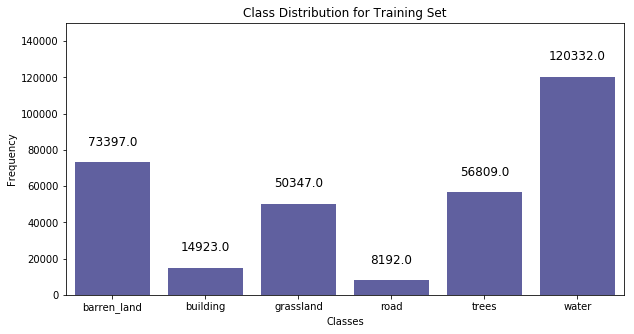

In [82]:
# View class distributions for training set
dist = train.simple.freq(inputs=['_label_'])['Frequency'][['CharVar','Frequency']]
plt.figure(figsize=(10,5))
bar = sns.barplot(x=dist['CharVar'].values, y=dist['Frequency'].values, color='blue', saturation=0.25)
plt.title('Class Distribution for Training Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Annotate bars with freq values
for p in bar.patches:
    bar.annotate(p.get_height(), (p.get_x() + (p.get_width()/2), p.get_height()), ha='center', va='center', 
                 fontsize=12, color='black', xytext=(0,20), textcoords='offset points')
p = bar.set_ylim(0,150000) 